In [1]:
### Imports ###
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from pathlib import Path
from typing import Any, Dict, Iterable

from google.colab import files
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
### Upload and set Kaggle API Token ###
# Prerequisite: Have your API token file in your local computer
# Edit this path if it does not match the name of your file
token_upload_path: Path = "./kaggle.json"
token_expected_dir: Path = "/root/.kaggle"

# Upload
if os.path.exists(token_upload_path):
  print(
      f"Skipping Kaggle API token upload, there is already something at: "
      f"{token_upload_path}"
  )
else:
  print("Please upload your Kaggle API token file.")
  files.upload()

# Move to expected dir
token_expected_path: Path = f"{token_expected_dir}/kaggle.json"
if os.path.isfile(token_expected_path):
  print(
      f"Skipping Kaggle API token move, there is already something at: "
      f"{token_expected_path}"    
  )
else:
  print(f"Moving Kaggle API token file to: {token_expected_path}")
  try:
    os.mkdir(token_expected_dir)
  except FileExistsError:
    pass  # Directory already exists
  except FileNotFoundError as e:
    print("Could not create Kaggle API token directory.")
    raise e
  shutil.copy(token_upload_path, token_expected_path)

Skipping Kaggle API token upload, there is already something at: ./kaggle.json
Skipping Kaggle API token move, there is already something at: /root/.kaggle/kaggle.json


In [3]:
### Import Dataset ###
!kaggle competitions download -c house-prices-advanced-regression-techniques
!mkdir -p ./dataset
!unzip house-prices-advanced-regression-techniques.zip -d ./dataset

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  house-prices-advanced-regression-techniques.zip
replace ./dataset/data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./dataset/data_description.txt  
  inflating: ./dataset/sample_submission.csv  
  inflating: ./dataset/test.csv      
  inflating: ./dataset/train.csv     


In [4]:
### Read Data Into DataFrame ###
df: pd.DataFrame = pd.read_csv("./dataset/train.csv")

In [5]:
### Visualize Raw Data ###
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


In [6]:
def list_non_numerical_vars(input: pd.DataFrame) -> Dict[str, Iterable[Any]]:
  """
  Finds non-numerical variables from the input and returns them in a key to
  unique values mapping.
  """
  obj_columns : Iterable[str] = list(input.select_dtypes(include=["object"]).columns)
  ret: Dict[str, Iterable[Any]] = {}
  for col in obj_columns:
    ret[col] = input[col].unique().tolist()
  return ret

In [7]:
### Find Out How to Preprocess the Data ###
non_numerical_vars: Dict[str, Iterable[Any]] = list_non_numerical_vars(df)
for key, val in non_numerical_vars.items():
  print(f"{key}:", val)

MSZoning: ['RL', 'RM', 'C (all)', 'FV', 'RH']
Street: ['Pave', 'Grvl']
Alley: [nan, 'Grvl', 'Pave']
LotShape: ['Reg', 'IR1', 'IR2', 'IR3']
LandContour: ['Lvl', 'Bnk', 'Low', 'HLS']
Utilities: ['AllPub', 'NoSeWa']
LotConfig: ['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3']
LandSlope: ['Gtl', 'Mod', 'Sev']
Neighborhood: ['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst', 'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes', 'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert', 'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU', 'Blueste']
Condition1: ['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA', 'RRNe']
Condition2: ['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe']
BldgType: ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs']
HouseStyle: ['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf', '2.5Fin']
RoofStyle: ['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed']
RoofMatl: ['CompShg', 'WdShngl', 

In [113]:
def preprocess(input: pd.DataFrame, 
               drop_categorical: bool = True, 
               drop_nan_threshold: float = 0.05) -> pd.DataFrame:
  """Handle variables with non-numerical values."""
  # We do not care about the ID field.
  ret = input.drop("Id", axis=1)

  # Some manipulations specific to our dataset.
  # Age is an important derivative variable.
  # We leave the other columns, RF algorithm will choose what's best.
  ret["Age"] = ret["YrSold"] - ret["YearBuilt"]

  if drop_categorical:
    vars: Iterable[str] = list(list_non_numerical_vars(ret).keys())
    ret = ret.drop(columns=vars, inplace=True)
  else:
    non_numerical_vars = list_non_numerical_vars(ret)
    for key, val in non_numerical_vars.items():
      for idx, item in enumerate(val):
        # One hot encoding
        new_col = f"{key}-{idx}"
        ret[new_col] = 0
        ret.loc[ret[key] == item, new_col] = 1
      ret.drop(columns=[key], inplace=True)

  # If more than a threshold ratio of a column is NaN,
  # we want to drop the column.
  missing_total = ret.isnull().sum().sort_values(ascending=False)
  missing_ratio = (ret.isnull().sum() / ret.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([missing_total, missing_ratio], axis=1, keys=["Total", "Ratio"])
  missing_cols = (missing_data[missing_data["Ratio"] > drop_nan_threshold]).index
  ret.drop((missing_data[missing_data["Ratio"] > drop_nan_threshold]).index, axis=1, inplace=True)
  
  # Replace missing values with most common values for that variable.
  remaining_cols = (missing_data[missing_data["Ratio"] <= drop_nan_threshold]).index.tolist()
  for col in remaining_cols:
    ret[col] = ret[col].fillna(ret[col].mode()[0])
  return ret

In [114]:
### See Preprocessing in Action ###
proc_df = preprocess(df, False)
proc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 304 entries, MSSubClass to SaleCondition-5
dtypes: float64(1), int64(303)
memory usage: 3.4 MB


In [115]:
### Split Data Into Test and Train Subsets
SEED = 562
y = proc_df["SalePrice"]
x = proc_df.drop(["SalePrice"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

In [116]:
### Do a Dummy Regression ###
rf_reg = RandomForestRegressor(n_estimators=3,
                               max_depth=2,
                               random_state=SEED)
# Regression
rf_reg.fit(x_train, y_train)
# Evaluation
y_pred = rf_reg.predict(x_test)

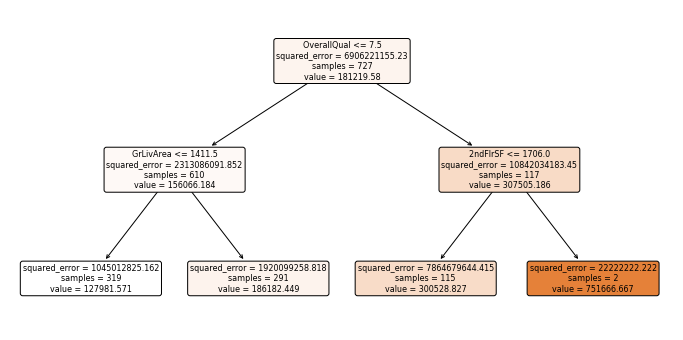

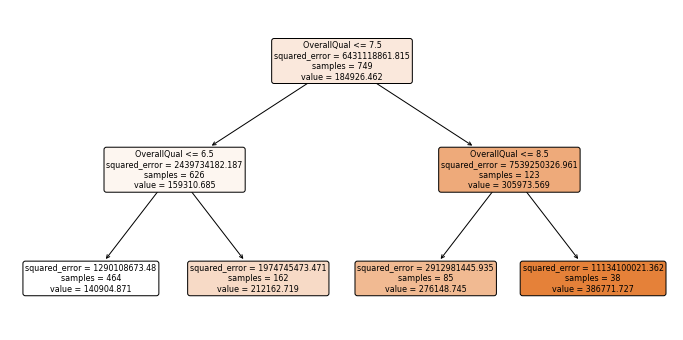

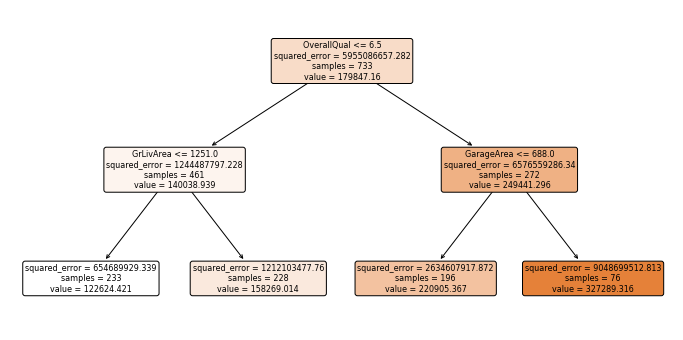

In [117]:
### Display the Forest ###
features = x.columns.values

for estimator in rf_reg.estimators_:
  plt.figure(figsize=(12,6))
  tree.plot_tree(estimator,
                 feature_names=features,
                 fontsize=8,
                 filled=True,
                 rounded=True)
plt.show()

In [118]:
### Print Metrics ###
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 32391.335190660564
Mean Squared Error: 1869217735.9222794
Root Mean Squared Error: 43234.450799359984


In [119]:
"""
Previous results should be terrible, which is expected as it
is just a demonstration.

Let's see if we can improve upon it using grid search to
optimize parameters.
"""
grid = {
    "n_estimators": [100, 200, 300],
    "max_features": [1.0, "sqrt", "log2"],
    "max_depth": [3, 4, 5, 6, 7],
    "random_state": [SEED],
}

# Start time
start_time = datetime.now()
print("Start:", start_time)

searcher = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid)
searcher.fit(x_train, y_train)

end_time = datetime.now()
print("End:", end_time)
print("Duration:", end_time - start_time)

Start: 2022-11-27 14:41:24.397600
End: 2022-11-27 14:44:24.243258
Duration: 0:02:59.845658


In [120]:
### Evaluate and Print Metrics ###
y_pred = searcher.predict(x_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 20300.8222958437
Mean Squared Error: 1061190748.5777041
Root Mean Squared Error: 32575.922835396454
